In [1]:
from network_wrangler import RoadwayNetwork
import osmnx as ox
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point
import networkx as nx
import folium
%config IPCompleter.greedy=True
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
STPAUL_DIR = os.path.join(os.getcwd(),'../','example','stpaul')
STPAUL_SHAPE_FILE = os.path.join(STPAUL_DIR,"shape.geojson")
STPAUL_LINK_FILE = os.path.join(STPAUL_DIR,"link.json")
STPAUL_NODE_FILE = os.path.join(STPAUL_DIR,"node.geojson")

In [3]:
net = RoadwayNetwork.read(link_file= STPAUL_LINK_FILE, node_file=STPAUL_NODE_FILE, shape_file=STPAUL_SHAPE_FILE, fast=True)

In [4]:
selection = {
    'link':[
        {'name': ['6th', 'Sixth', 'sixth']},
        {'lanes': [1, 2]}
        ],
     'A':{'osmnodeid': '187899923'},
     'B':{'osmnodeid': '187865924'},
}

In [5]:
# build link selection query
sel_query = ''
count = 1
if 'link' in selection.keys():
    for d in selection['link']:
        for key, value in d.items():
            key = key.lower()
            if isinstance(value, list):
                sel_query = sel_query + '('
                v = 1
                for i in value:   # building an OR query with each element in list
                    if isinstance(i, str):
                        sel_query = sel_query + key + '.str.contains("' + i + '")'
                    else:
                        sel_query = sel_query + key + '==' + str(i)
                    if v!= len(value):
                        sel_query = sel_query + ' or '
                        v = v + 1
                sel_query = sel_query + ')'
            else:
                sel_query = sel_query + key + ' == ' + '"' + str(value) + '"'

            if count != len(selection['link']):
                sel_query = sel_query + ' and '
            count = count + 1

In [6]:
sel_query

'(name.str.contains("6th") or name.str.contains("Sixth") or name.str.contains("sixth")) and (lanes==1 or lanes==2)'

In [7]:
#A_id = selection['A']['osmnodeid']
#B_id = selection['B']['osmnodeid']
for key, val in selection['A'].items():
    node_key = key
    A_id = val
for key, val in selection['B'].items():
    node_key = key
    B_id = val

In [8]:
net.links_df.columns = map(str.lower, net.links_df.columns)
net.nodes_df.columns = map(str.lower, net.nodes_df.columns)
net.nodes_df['x'] = net.nodes_df['geometry'].apply(lambda g: g.x)
net.nodes_df['y'] = net.nodes_df['geometry'].apply(lambda g: g.y)

In [9]:
candidate_links = net.links_df.query(sel_query, engine='python')

In [10]:
candidate_links['weight'] = 1

In [11]:
node_list_osmnodeids = list(candidate_links['u']) + list(candidate_links['v'])

In [12]:
def add_breadth(candidate_links, nodes, links):
    #add outbound and inbound reference IDs from existing nodes
    node_list_osmnodeids = list(candidate_links['u']) + list(candidate_links['v'])
    candidate_nodes = nodes[nodes[node_key].isin(node_list_osmnodeids)]
    links_id_to_add = list(candidate_nodes['outboundreferenceid']) + list(candidate_nodes['inboundreferenceid'])
    links_id_to_add = [item for sublist in links_id_to_add for item in sublist if item != '']
    for id in links_id_to_add:
        if id not in candidate_links['id'].tolist():
            link_to_add = links[links['id'] == id]
            link_to_add['weight'] = 100
            candidate_links.append(link_to_add)
            
    return candidate_links

In [13]:
i = 0
MAX_BREADTH = 10
while A_id not in node_list_osmnodeids and B_id not in node_list_osmnodeids and i < MAX_BREADTH:
   candidate_links = add_breadth(candidate_links, net.nodes_df, net.links_df)
   i += 1

In [14]:
node_list_osmnodeids = list(candidate_links['u']) + list(candidate_links['v'])
candidate_nodes = net.nodes_df[net.nodes_df[node_key].isin(node_list_osmnodeids)]

In [15]:
non_candidate_links = net.links_df[~net.links_df.index.isin(candidate_links.index)]
non_candidate_links['weight'] = 1000

In [16]:
# After applying different weights to the links, still using the entire network (nodes/links) instead of candidate network
# TODO: Discuss this part

#graph_nodes = candidate_nodes.drop(['inboundreferenceid', 'outboundreferenceid'], axis=1)
graph_nodes = net.nodes_df.drop(['inboundreferenceid', 'outboundreferenceid'], axis=1)
graph_nodes.set_index(node_key, inplace = True)
graph_nodes.crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'
graph_nodes.gdf_name = "network_nodes"

#graph_edges = candidate_links
graph_edges = candidate_links.append(non_candidate_links)

In [17]:
G = ox.gdfs_to_graph(graph_nodes, graph_edges)

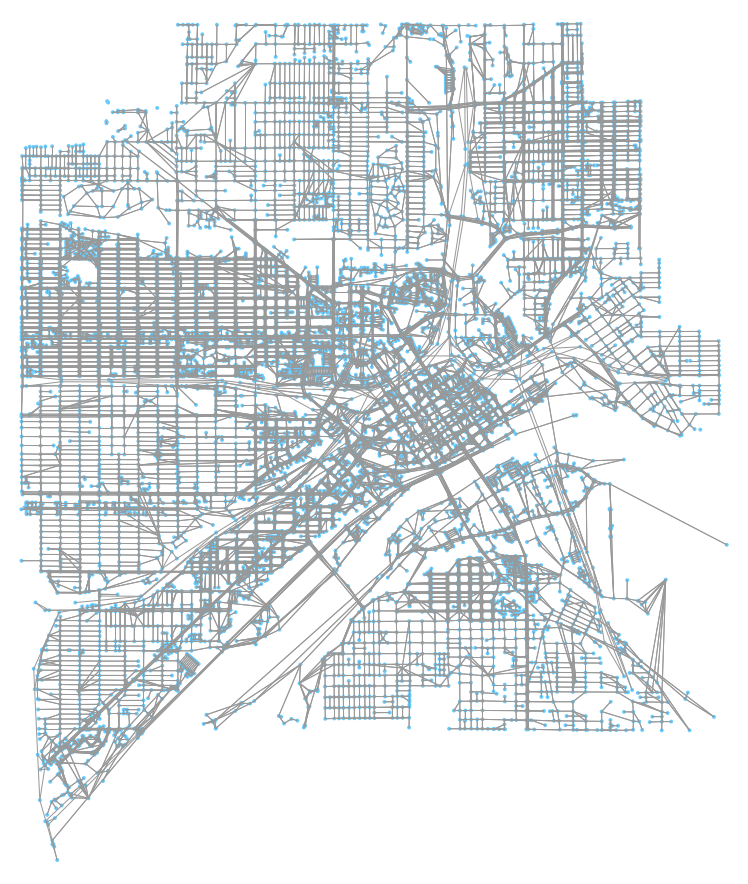

(<Figure size 1152x1152 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19b80d6db00>)

In [18]:
ox.plot_graph(G, fig_height=16, fig_width=16)

#renders for candidate graph but takes forever for entire network
#m = ox.plot_graph_folium(G, edge_color = 'green', edge_width = 3)
#folium.Marker(location=[graph_nodes.loc[A_id]['y'], graph_nodes.loc[A_id]['x']], icon=folium.Icon(color='blue'), tooltip='A Node').add_to(m)
#folium.Marker(location=[graph_nodes.loc[B_id]['y'], graph_nodes.loc[B_id]['x']], icon=folium.Icon(color='blue'), tooltip='B Node').add_to(m)
#m

In [19]:
sp_route = nx.shortest_path(G, A_id, B_id, weight = 'weight')

In [20]:
sp_route

['187899923', '187858777', '187923585', '187865924']

In [21]:
#ox.plot_graph_route(G, sp_route, fig_height=20, fig_width=20)
r = ox.plot_route_folium(G, sp_route)
folium.Marker(location=[graph_nodes.loc[A_id]['y'], graph_nodes.loc[A_id]['x']], icon=folium.Icon(color='blue'), tooltip='A Node').add_to(r)
folium.Marker(location=[graph_nodes.loc[B_id]['y'], graph_nodes.loc[B_id]['x']], icon=folium.Icon(color='blue'), tooltip='B Node').add_to(r)
r

In [22]:
#sp_links = candidate_links[candidate_links['u'].isin(sp_route) & candidate_links['v'].isin(sp_route)]
sp_links = graph_edges[graph_edges['u'].isin(sp_route) & graph_edges['v'].isin(sp_route)]

In [23]:
sp_links

,lanes,link_id,osmlanes,access,area,bridge,geometryid,highway,id,isbikelink,isdrivelink,istranlink,iswalklink,junction,key,length,locationreferences,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width,geometry,weight
1125,1,85208,0.0,,,,f40c90c87447dca8c1d89b35e2175778,tertiary,f89fec3332dd503f754dc5adde048fa3,0,1,0,0,,0.0,111.992,"[{'sequence': 1, 'point': [-93.0928707, 44.947...",,East 6th Street,True,223371528,,,,187858777,187923585,,"LINESTRING (-93.09287070000001 44.9476402, -93...",1
4498,1,134574,0.0,,,,878abbf556627618b2f1c8e3ab45f04d,tertiary,d6b3b088666d86081ff7e64399cfc34f,0,1,0,0,,0.0,117.292,"[{'sequence': 1, 'point': [-93.091634, 44.9482...",,East 6th Street,True,223371529,,,,187899923,187858777,,"LINESTRING (-93.091634 44.9482284, -93.0928707...",1
5570,1,154035,0.0,,,,1e802737854e3202753c8641086352d8,tertiary,23f4bf6121c4220c46c530eb95664cb4,1,1,0,0,,0.0,114.436,"[{'sequence': 1, 'point': [-93.0940445, 44.947...",,East 6th Street,True,637912019,,,,187923585,187865924,,"LINESTRING (-93.0940445 44.9470709, -93.095249...",1


In [24]:
# shortest path links may or may not satify the initial selection criteria
# filter again based on the selection query
sel_data = sp_links.query(sel_query, engine='python')
sel_data.head()

,lanes,link_id,osmlanes,access,area,bridge,geometryid,highway,id,isbikelink,isdrivelink,istranlink,iswalklink,junction,key,length,locationreferences,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width,geometry,weight
1125,1,85208,0.0,,,,f40c90c87447dca8c1d89b35e2175778,tertiary,f89fec3332dd503f754dc5adde048fa3,0,1,0,0,,0.0,111.992,"[{'sequence': 1, 'point': [-93.0928707, 44.947...",,East 6th Street,True,223371528,,,,187858777,187923585,,"LINESTRING (-93.09287070000001 44.9476402, -93...",1
4498,1,134574,0.0,,,,878abbf556627618b2f1c8e3ab45f04d,tertiary,d6b3b088666d86081ff7e64399cfc34f,0,1,0,0,,0.0,117.292,"[{'sequence': 1, 'point': [-93.091634, 44.9482...",,East 6th Street,True,223371529,,,,187899923,187858777,,"LINESTRING (-93.091634 44.9482284, -93.0928707...",1
5570,1,154035,0.0,,,,1e802737854e3202753c8641086352d8,tertiary,23f4bf6121c4220c46c530eb95664cb4,1,1,0,0,,0.0,114.436,"[{'sequence': 1, 'point': [-93.0940445, 44.947...",,East 6th Street,True,637912019,,,,187923585,187865924,,"LINESTRING (-93.0940445 44.9470709, -93.095249...",1


In [25]:
sel_indices = sel_data.index.tolist()
sel_indices

[1125, 4498, 5570]